### SETUP INICIAL DO PROJETO

In [1]:

#importação das bibliotecase e pacotes necessários para a análise

import json
import numpy as np
import os
import pandas as pd
import pandas_gbq as gbq
import re
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from google.cloud import bigquery
from google.cloud.bigquery_storage import BigQueryReadClient
from google.oauth2 import service_account

# Carrega o .env: onde estão as credenciais do projeto/repositório
load_dotenv("/mnt/c/Users/wrpen/OneDrive/Desktop/df_lh/.env")

# Detectar ambiente: como eu estou usando wsl-ubuntu, no VS Code  -  Windows, estava dando conflitos de path
if os.name == "nt":  # se Windows
    credentials_path = r"C:\Temp\desafiolh-445818-3cb0f62cb9ef.json"
else:  # se WSL/Linux
    credentials_path = "/mnt/c/Temp/desafiolh-445818-3cb0f62cb9ef.json"

# Parâmetros injetados pelo Papermill ou definidos manualmente, caso não existam no ambiente
# Tables_to_process: lista de tabelas que serão processadas
# Output_dataset: nome do dataset onde os dados processados serão armazenados, neste caso, raw_data_cleaned
if 'tables_to_process' not in locals():
    tables_to_process = [
        "desafioadventureworks-446600.raw_data.purchasing-vendor"       
    ]

if 'output_dataset' not in locals():
    output_dataset = "desafioadventureworks-446600.raw_data_cleaned"

# Configs do cliente BigQuery: input de project e location de acordo com dados no Bigquery
credentials = service_account.Credentials.from_service_account_file(credentials_path)
client = bigquery.Client(credentials=credentials, project=os.getenv("BIGQUERY_PROJECT"), location="us-central1")


In [2]:
# Print com a tabela que vai ser processada nesse notebook

print("Tabelas a processar:", tables_to_process)

Tabelas a processar: ['desafioadventureworks-446600.raw_data.purchasing-vendor']


In [3]:
# Nome do dataset no Bigquery com os dados brutos (.csv) extraídos pelo Meltano 
dataset_id = 'raw_data'
print(dataset_id)

# Lista de tabelas do dataset raw_data no Bigquery
tables = client.list_tables('raw_data')
print("Tabelas disponíveis:")
for table in tables:
    print(table.table_id)

raw_data
Tabelas disponíveis:
humanresources-employee
person-address
person-businessentity
person-person
person-stateprovince
production-location
production-product
production-productcategory
production-productcosthistory
production-productinventory
production-productsubcategory
purchasing-purchaseorderdetail
purchasing-purchaseorderheader
purchasing-vendor
sales-creditcard
sales-customer
sales-salesorderdetail
sales-salesorderheader
sales-salesperson
sales-salesterritory
sales-store


# Exploratory Data Analysis (EDA) e Data Cleaning

### Glossário dos dados:

O termo ''doc:'', situado no rodapé de algumas cells, indica algo como:

- documentação: documentar decisões, análises e resultados;

- abreviações de termos, como bkp, df, entre outros.

In [4]:
# Configuração para que o df exiba todas as colunas e todas as linhas completas, e também, exiba o formato numérico com 2 dígitos após a vírgula

pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 10000)
pd.options.display.float_format = '{:.2f}'.format


#doc: df = dataframe  

In [5]:
# Dicionário para armazenar os df processados
df_processados = {}

# Iteração das tabelas e armazenamento em df
for input_table in tables_to_process:
    print(f"Processando tabela: {input_table}")
    
    # Nome da tabela com substituição de '-' por '_'
    table_name = input_table.split(".")[-1].replace("-", "_")  
    
    # Ler os dados da tabela do BigQuery para um df
    print("Lendo os dados do BigQuery...")
    query = f"SELECT * FROM `{input_table}`"
    table_data = client.query(query).to_dataframe()
    
    # Armazenar o df no dicionário
    df_processados[table_name] = table_data
    print(f"Tabela {table_name} processada e armazenada com sucesso.")

# Print de validação
print("Todas as tabelas foram processadas com sucesso!")


Processando tabela: desafioadventureworks-446600.raw_data.purchasing-vendor
Lendo os dados do BigQuery...
Tabela purchasing_vendor processada e armazenada com sucesso.
Todas as tabelas foram processadas com sucesso!


In [6]:
# Listar todas as variáveis criadas dinamicamente
for table_name in df_processados.keys():
    print(f"Variável criada: {table_name}")  

Variável criada: purchasing_vendor


In [7]:
# Atribuir o df a uma variável com nome mais simples
purchasing_vendor = df_processados['purchasing_vendor']

print(f"Colunas: {purchasing_vendor.shape[1]}\nLinhas: {purchasing_vendor.shape[0]}")

Colunas: 8
Linhas: 104


In [8]:
purchasing_vendor.head()

,businessentityid,accountnumber,name,creditrating,preferredvendorstatus,activeflag,purchasingwebserviceurl,modifieddate
0,1532,KNOPFLER0001,Knopfler Cycles,1,True,True,None,2012-01-29 00:00:00+00:00
1,1546,GREENLA0001,Green Lake Bike Company,1,True,True,None,2012-01-29 00:00:00+00:00
2,1592,LINDELL0001,Lindell,1,True,True,None,2012-01-29 00:00:00+00:00
3,1618,METROSP0001,Metro Sport Equipment,1,True,True,None,2012-01-29 00:00:00+00:00
4,1620,LAKEWOOD0001,Lakewood Bicycle,1,True,True,None,2012-01-29 00:00:00+00:00


In [9]:
# Obter os valores distintos da coluna
distinct_values = purchasing_vendor['purchasingwebserviceurl'].unique()

# Contar a quantidade de valores distintos
distinct_count = purchasing_vendor['purchasingwebserviceurl'].nunique()

# Exibir os resultados
print(f"Quantidade de valores distintos: {distinct_count}")
print("Valores distintos:")
print(distinct_values)


Quantidade de valores distintos: 6
Valores distintos:
[None 'www.litwareinc.com/' 'www.northwindtraders.com/' 'www.adatum.com/'
 'www.wideworldimporters.com/' 'www.treyresearch.net/'
 'www.proseware.com/']


In [10]:
# Remover a coluna 'purchasingwebserviceurl'
purchasing_vendor = purchasing_vendor.drop(columns=['purchasingwebserviceurl'])


In [11]:
# Identificar duplicadas com base em 'businessentityid'
duplicadas = purchasing_vendor[
    purchasing_vendor.duplicated(subset=['businessentityid'], keep=False)
]

# Verificar se existem duplicadas
if not duplicadas.empty:
    # Ordenar duplicadas por 'businessentityid' e 'modifieddate'
    duplicadas_ordenadas = duplicadas.sort_values(by=['businessentityid', 'modifieddate'])

    # Exibir duplicadas ordenadas
    print("duplicadas ordenadas:")
    print(duplicadas_ordenadas)
else:
    print("Não foram encontradas duplicadas.")

Não foram encontradas duplicadas.


In [12]:
# Remover duplicadas mantendo a última ocorrência com base em 'modifieddate', pois ela que indica a data da última modificação nos dados
# Importante, pois se houver erro na ingestão (duplicação), mantém os dados integros.

purchasing_vendor = purchasing_vendor.drop_duplicates(subset=['businessentityid'], keep='last')

print(f"Linhas após remover duplicadas (baseando-se na última 'modifieddate'): {len(purchasing_vendor)}")

#bkp dos dados brutos
raw_data_bkp_2_sem_duplicadas = purchasing_vendor.copy()


#doc: bkp = backup (cópia)

Linhas após remover duplicadas (baseando-se na última 'modifieddate'): 104


In [13]:
# Ordenar e exibir o df por 'businessentityid'
purchasing_vendor = purchasing_vendor.sort_values(by=['businessentityid'])

print(purchasing_vendor)

    businessentityid accountnumber                       name  creditrating  preferredvendorstatus  activeflag              modifieddate
6               1492  AUSTRALI0001    Australia Bike Retailer             1                   True        True 2011-12-23 00:00:00+00:00
85              1494  ALLENSON0001            Allenson Cycles             2                   True        True 2011-04-25 00:00:00+00:00
15              1496  ADVANCED0001          Advanced Bicycles             1                   True        True 2011-04-25 00:00:00+00:00
92              1498    TRIKES0001               Trikes, Inc.             2                   True        True 2012-02-03 00:00:00+00:00
26              1500   MORGANB0001    Morgan Bike Accessories             1                   True        True 2012-02-02 00:00:00+00:00
..               ...           ...                        ...           ...                    ...         ...                       ...
14              1690  BLOOMING0001     Bl

In [14]:
# Iterar por todas as colunas do df, para verificar valores ausentes

# Verificar valores ausentes na coluna
for column in purchasing_vendor.columns:   
    missing_rows = purchasing_vendor[purchasing_vendor[column].isnull()]
    print(f"Coluna '{column}': {missing_rows.shape[0]} linhas ausentes.")
    
# Mostrar as primeiras linhas ausentes, se preciso for, limitar o head() para dar menos outputs ou limitar os outputs
    if not missing_rows.empty:
        print(f"Exibindo as primeiras linhas com valores ausentes em '{column}':")
        print(missing_rows.head(), "\n")
    else:
        print(f"Nenhuma linha com valores ausentes em '{column}'.\n")

Coluna 'businessentityid': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'businessentityid'.

Coluna 'accountnumber': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'accountnumber'.

Coluna 'name': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'name'.

Coluna 'creditrating': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'creditrating'.

Coluna 'preferredvendorstatus': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'preferredvendorstatus'.

Coluna 'activeflag': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'activeflag'.

Coluna 'modifieddate': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'modifieddate'.



In [15]:
# Valores únicos por coluna, para verificar se colunas como flags, normalmente booleanas, possuem apenas 1 ou 2 valores.

valores_unicos = purchasing_vendor.nunique(dropna=False)

print("Valores únicos incluindo NaN:")
print(valores_unicos)

#doc: currentflag possue somente 1 valor, o que indica que pode ser somente valores True ou False.

Valores únicos incluindo NaN:
businessentityid         104
accountnumber            104
name                     104
creditrating               5
preferredvendorstatus      2
activeflag                 2
modifieddate              10
dtype: int64


In [16]:
#verificar informações do df
purchasing_vendor.info()

<class 'pandas.core.frame.DataFrame'>
Index: 104 entries, 6 to 84
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   businessentityid       104 non-null    Int64              
 1   accountnumber          104 non-null    object             
 2   name                   104 non-null    object             
 3   creditrating           104 non-null    Int64              
 4   preferredvendorstatus  104 non-null    boolean            
 5   activeflag             104 non-null    boolean            
 6   modifieddate           104 non-null    datetime64[us, UTC]
dtypes: Int64(2), boolean(2), datetime64[us, UTC](1), object(2)
memory usage: 5.5+ KB


In [17]:
#avaliando as variáveis qualitativas*

coluna_quantitativa = ["preferredvendorstatus", "activeflag","creditrating"]
for col in coluna_quantitativa:
    counts = purchasing_vendor[col].value_counts().nlargest(10)
    percentages = (counts / purchasing_vendor.shape[0] * 100).map("{:.2f}%".format)
    summary = pd.DataFrame({"qtde.": counts, "%": percentages})
    print(summary)    


#doc*: variáveis qualitativas são um tipo de variável estatística que representam características ou atributos dos dados, sem serem medidas numericamente
#      no nosso caso, "preferredvendorstatus", "activeflag, por exemplo

#doc: a maioria dos fornecedores (quase 90%) é marcada como "preferidos", indicando que são priorizados no processo de compra.

#doc: a grande maioria dos fornecedores (96%) está ativa, sugerindo que o sistema mantém apenas um pequeno número de registros inativos.

#doc: a predominância de notas 1 (80.77%) indica que a empresa prioriza trabalhar com fornecedores de alta credibilidade, o que reduz riscos no processo de compras


                       qtde.       %
preferredvendorstatus               
True                      93  89.42%
False                     11  10.58%
            qtde.       %
activeflag               
True          100  96.15%
False           4   3.85%
              qtde.       %
creditrating               
1                84  80.77%
2                 9   8.65%
3                 7   6.73%
4                 2   1.92%
5                 2   1.92%


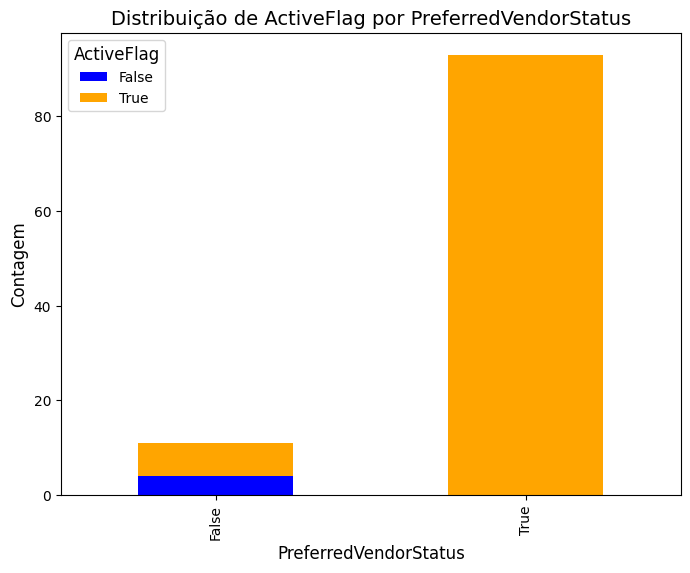

In [18]:
# Criar um gráfico de barras empilhadas
cross_tab = pd.crosstab(purchasing_vendor['preferredvendorstatus'], purchasing_vendor['activeflag'])
cross_tab.plot(kind='bar', stacked=True, figsize=(8, 6), color=['blue', 'orange'])

# Personalizar o gráfico
plt.title('Distribuição de ActiveFlag por PreferredVendorStatus', fontsize=14)
plt.xlabel('PreferredVendorStatus', fontsize=12)
plt.ylabel('Contagem', fontsize=12)
plt.legend(title='ActiveFlag', fontsize=10, title_fontsize=12)
plt.grid(False)  # Remover grade
plt.show()


#doc: status de fornecedor preferido é distribuído entre os ativos e inativos.

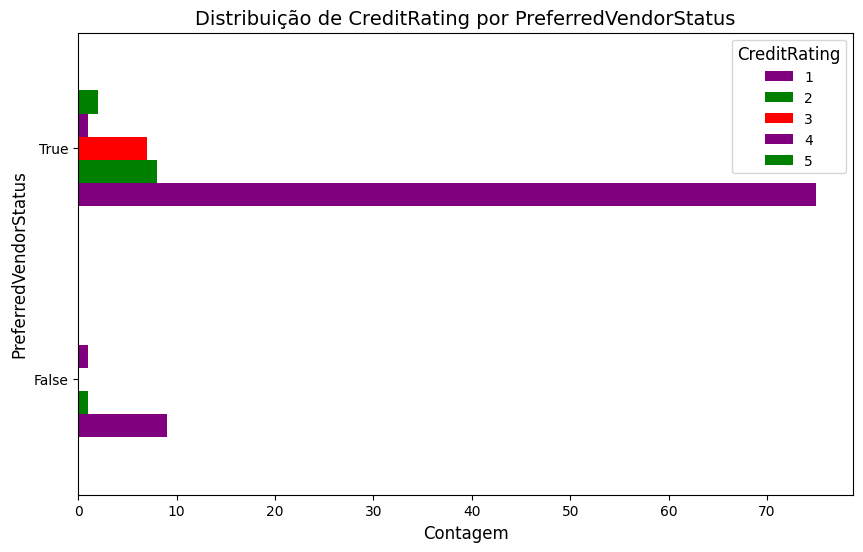

In [19]:
# Agrupar dados e plotar
preferred_credit = purchasing_vendor.groupby('preferredvendorstatus')['creditrating'].value_counts().unstack()
preferred_credit.plot(kind='barh', figsize=(10, 6), color=['purple', 'green', 'red'])

# Personalizar o gráfico
plt.title('Distribuição de CreditRating por PreferredVendorStatus', fontsize=14)
plt.xlabel('Contagem', fontsize=12)
plt.ylabel('PreferredVendorStatus', fontsize=12)
plt.legend(title='CreditRating', fontsize=10, title_fontsize=12)
plt.grid(False)  # Remover grade
plt.show()


#doc: a verificar como a avaliação de crédito é distribuída por status de fornecedor preferido.

In [20]:
purchasing_vendor.info()

<class 'pandas.core.frame.DataFrame'>
Index: 104 entries, 6 to 84
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   businessentityid       104 non-null    Int64              
 1   accountnumber          104 non-null    object             
 2   name                   104 non-null    object             
 3   creditrating           104 non-null    Int64              
 4   preferredvendorstatus  104 non-null    boolean            
 5   activeflag             104 non-null    boolean            
 6   modifieddate           104 non-null    datetime64[us, UTC]
dtypes: Int64(2), boolean(2), datetime64[us, UTC](1), object(2)
memory usage: 5.5+ KB


In [21]:
# Atualizar o dicionário df_processados com o df ajustado
df_processados['purchasing_vendor'] = purchasing_vendor

In [22]:
# Padronizar colunas com valores textuais
purchasing_vendor['name'] = purchasing_vendor['name'].str.strip().str.upper()
purchasing_vendor['accountnumber'] = purchasing_vendor['accountnumber'].str.strip().str.upper()

print(purchasing_vendor.head())

#doc: padronizar as strings nessa etapa, contribui para a execução das demais etapas do pipeline

    businessentityid accountnumber                     name  creditrating  preferredvendorstatus  activeflag              modifieddate
6               1492  AUSTRALI0001  AUSTRALIA BIKE RETAILER             1                   True        True 2011-12-23 00:00:00+00:00
85              1494  ALLENSON0001          ALLENSON CYCLES             2                   True        True 2011-04-25 00:00:00+00:00
15              1496  ADVANCED0001        ADVANCED BICYCLES             1                   True        True 2011-04-25 00:00:00+00:00
92              1498    TRIKES0001             TRIKES, INC.             2                   True        True 2012-02-03 00:00:00+00:00
26              1500   MORGANB0001  MORGAN BIKE ACCESSORIES             1                   True        True 2012-02-02 00:00:00+00:00


In [23]:

# Garantir que apenas tabelas únicas sejam exportadas
unique_df_processados = {k: v for k, v in df_processados.items()}

# Exportar tabelas para o BigQuery
for table_name, df_cleaned in unique_df_processados.items():
    # Nome da tabela no BigQuery
    output_table = f"{output_dataset}.{table_name}"

    # Configurar job de exportação
    job_config = bigquery.LoadJobConfig(
        write_disposition="WRITE_TRUNCATE"  
    )
    
    # Exportar DataFrame para o BigQuery
    job = client.load_table_from_dataframe(df_cleaned, output_table, job_config=job_config)
    job.result()

    print(f"Tabela {table_name} exportada com sucesso para {output_table}.")

Tabela purchasing_vendor exportada com sucesso para desafioadventureworks-446600.raw_data_cleaned.purchasing_vendor.
